In [59]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
from util import random_mini_batches

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

st = tf.contrib.bayesflow.stochastic_tensor
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [60]:
# some constants
LEARNING_RATE = 0.002
BETA1 = 0.6
BATCH_SIZE = 100
EPOCHS = 20
SAVE_SAMPLE_PERIOD = 50

In [61]:
def lrelu(x, alpha =0.2):
    return tf.maximum(alpha*x,x)

In [62]:
class DenseLayer(object):
    
    def __init__(self,
                 name,
                 mi, mo,
                 apply_batch_norm,
                 f=tf.nn.relu):
        
        #self.mi = mi
        #self.mo = mo
        
        self.W = tf.get_variable(
            'W_%s' %name,
            shape=(mi,mo),
            initializer=tf.glorot_normal_initializer(),
        )
        self.b = tf.get_variable(
            'b_%s' %name,
            shape=(mo, ),
            initializer=tf.zeros_initializer(),
        )
        
        self.f = f
        self.name = name
        self.apply_batch_norm = apply_batch_norm
        
        
    def forward(self, X, reuse, is_training):
        Z = tf.matmul(X,self.W) + self.b
        
        if self.apply_batch_norm:
            
            Z = tf.contrib.layers.batch_norm(
                Z,
                decay=0.99,
                updates_collections=None,
                epsilon=1e-5,
                scale=True,
                is_training = is_training,
                reuse=reuse,
                scope = self.name,
            )
            
        return self.f(Z)
    
    def set_session(self, session):
        
        self.session = session

In [63]:
class VariationalAutoencoder:
    
    
    def __init__(self, D, sizes):
        
        #size of every layer in the encoder
        #up to the latent layer, decoder
        #will have reverse shape
        self.sizes = sizes
        self.latent_dims = sizes['layer_sizes'][-1][0]
        self.D=D
        
        self.X = tf.placeholder(
            tf.float32,
            shape=(None, self.D),
            name='X'
        )
        
        self.batch_sz = tf.placeholder(
            tf.float32,
            shape=(),
            name='batch_sz'
        )
        
        #builds the encoder and outputs a Z distribution
        self.Z = self.build_encoder(self.X, self.sizes)
        
        #builds decoder from Z distribution
        logits = self.build_decoder(self.Z, self.sizes)
        
        #builds X_hat distribution from decoder output
        self.X_hat_distribution = Bernoulli(logits=logits)
        
        
        #posterior predictive
        
        with tf.variable_scope('encoder') as scope:
            scope.reuse_variables
            self.Z_dist = self.encode(
                self.X, reuse=True, is_training=False,
            )#self.X or something on purpose?

                                                   
        with tf.variable_scope('decoder') as scope:
            scope.reuse_variables()
            sample_logits = self.decode(
                self.Z_dist, reuse=True, is_training=False,
            )
            
        self.posterior_predictive_dist = Bernoulli(logits=sample_logits)
        self.posterior_predictive = self.posterior_predictive_dist.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(sample_logits)
        
        #prior predictive from prob

        standard_normal = Normal(
          loc=np.zeros(self.latent_dims, dtype=np.float32),
          scale=np.ones(self.latent_dims, dtype=np.float32)
        )

        Z_std = standard_normal.sample(1)

        with tf.variable_scope('decoder') as scope:
            scope.reuse_variables()
            logits_from_prob = self.decode(
                Z_std, reuse=True, is_training=False,
            )
        
        prior_predictive_dist = Bernoulli(logits=logits_from_prob)
        self.prior_predictive = prior_predictive_dist.sample()
        self.prior_predictive_probs = tf.nn.sigmoid(logits_from_prob)


        # prior predictive from input

        self.Z_input = tf.placeholder(tf.float32, shape=(None, self.latent_dims))
        
        with tf.variable_scope('decoder') as scope:
            scope.reuse_variables()    
            logits_from_input = self.decode(
                self.Z_input, reuse=True, is_training=False,
            )
        
        input_predictive_dist = Bernoulli(logits=logits_from_input)
        self.prior_predictive_from_input= input_predictive_dist.sample()
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits_from_input)

        
        #cost
        kl = tf.reduce_sum(
            tf.contrib.distributions.kl_divergence(
                self.Z.distribution,
                standard_normal),
            1
        )
        
        
        expected_log_likelihood = tf.reduce_sum(
              self.X_hat_distribution.log_prob(self.X),
              1
        )
        
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=LEARNING_RATE, #(0.001)
            beta1=BETA1,
        ).minimize(-self.elbo)

    def build_encoder(self, X, sizes):
        
        with tf.variable_scope('encoder') as scope:
            
            self.encoder_layers=[]
            M_in = self.D
            count = 0
            for M_out, apply_batch_norm in sizes['layer_sizes'][:-1]:
                
                name = 'enc_layer_%s' %count
                count += 1
                
                layer = DenseLayer(name, M_in, M_out, apply_batch_norm, lrelu)
                self.encoder_layers.append(layer)
                M_in = M_out
        
            #no activation of last layer and need 2
            #times as many units (M means and M stddevs)
            name = 'enc_layer_%s' %count
            last_enc_layer = DenseLayer(name, M_in, 2*self.latent_dims, apply_batch_norm=False, f=lambda x: x)
            self.encoder_layers.append(last_enc_layer)
            
            return self.encode(X)
        
    def encode(self, X, reuse=None, is_training=True):
        #propagate X until end of encoder
        output=X
        
        for layer in self.encoder_layers:
            output = layer.forward(output, reuse, is_training)
        
        
        #get means and stddev from last encoder layer
        self.means = output[:, :self.latent_dims]
        self.stddev = tf.nn.softplus(output[:,self.latent_dims:])+1e-6
        
        # get a sample of Z, we need to use a stochastic tensor
        # in order for the errors to be backpropagated past this point
        
        with st.value_type(st.SampleValue()):
            Z = st.StochasticTensor(Normal(loc=self.means, scale=self.stddev))
        
        return Z
    
        #build decoder
    def build_decoder(self, Z, sizes):
        
        with tf.variable_scope('decoder') as scope:
            
            self.decoder_layers =[]
            
            M_in = self.latent_dims

            count=0
            for i in range(len(sizes['layer_sizes'])-1,0,-1):
                
                name = 'dec_layer_%s' %count
                count +=1
                M_out, apply_batch_norm = sizes['layer_sizes'][i]
                
                layer = DenseLayer(name, M_in, M_out, apply_batch_norm)
                self.decoder_layers.append(layer)
                M_in = M_out

            # the decoder's final layer should technically go through a sigmoid
            # so that the final output is a binary probability (e.g. Bernoulli)
            # but Bernoulli accepts logits (pre-sigmoid) so we will take those
            # so no activation function is needed at the final layer
            
            name = 'dec_layer_%s' %count
            last_dec_layer = DenseLayer(name, M_in, self.D, apply_batch_norm=False, f=lambda x: x)
            self.decoder_layers.append(last_dec_layer)
            
            return self.decode(Z)
    
    def decode(self, Z, reuse=None, is_training=True):
        
        output = Z
        
        for layer in self.decoder_layers:
            output = layer.forward(output, reuse, is_training)
        
        return output
    
    def set_session(self, session):
        
        self.session = session
        
        for layer in self.encoder_layers:
            layer.set_session(session)
            
        for layer in self.decoder_layers:
            layer.set_session(session)  
        
    def fit(self, X):
        costs = []
        n_batches = len(X)//BATCH_SIZE
        print("# batches", n_batches)
        
        for i in range(EPOCHS):
            print("Epoch", i)
            np.random.shuffle(X)
            
            for j in range(n_batches):
                
                X_batch = X[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                _, c = self.session.run((self.train_op,self.elbo),feed_dict={self.X:X_batch, self.batch_sz:BATCH_SIZE})
                c /= BATCH_SIZE
                costs.append(c)
                
                if j % 250 == 0:
                    print("on iter %d, cost: %.3f" %(j, c))
                
            plt.plot(costs)
            plt.show
            
    def transform(self, X):
        return self.session.run(
          self.means,
          feed_dict={self.X: X}
        )

    #def prior_predictive_with_input(self, Z):
    #    return self.session.run(
    #      self.prior_predictive_from_input_probs,
    #      feed_dict={self.Z_input: Z}
    #    )

    def posterior_predictive_sample(self, X):
        # returns a sample from p(x_new | X)
        return self.session.run(self.posterior_predictive_probs, feed_dict={self.X: X})

    def prior_predictive_sample_with_probs(self):
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        return self.session.run((self.prior_predictive, self.prior_predictive_probs))

In [64]:
def test_vae():

    X_train = mnist.train.images
    #X_train = X_train/255
    X_train = (X_train>0.5).astype(np.float32)
    
    X_test = mnist.test.images
    #X_test = X_test/255
    X_test = (X_test>0.5).astype(np.float32)

    
    N, D = X_train.shape
    
    sizes = {
        'layer_sizes':[(300,False),(200,True),(100,True)]
    }
    tf.reset_default_graph()
    vae = VariationalAutoencoder(D, sizes)
    # set up session and variables for later
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init_op)
        vae.set_session(sess)
        vae.fit(X_train)

        done = False
        while not done:
        
            i = np.random.choice(len(X_test))
            x = X_test[i]
            im = vae.posterior_predictive_sample([x]).reshape(28, 28)
            
            plt.subplot(1,2,1)
            plt.imshow(x.reshape(28, 28), cmap='gray')
            plt.title("Original")
            
            plt.subplot(1,2,2)
            plt.imshow(im, cmap='gray')
            plt.title("Sampled")
            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

  # plot output from random samples in latent space
        done = False
        while not done:
        
            im, probs = vae.prior_predictive_sample_with_probs()
            
            im = im.reshape(28, 28)
            
            probs = probs.reshape(28, 28)
            
            plt.subplot(1,2,1)
            plt.imshow(im, cmap='gray')
            plt.title("Prior predictive sample")
            
            plt.subplot(1,2,2)
            plt.imshow(probs, cmap='gray')
            plt.title("Prior predictive probs")
            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

# batches 550
Epoch 0
on iter 0, cost: -593.542
on iter 250, cost: -138.900
on iter 500, cost: -125.790
Epoch 1
on iter 0, cost: -118.838
on iter 250, cost: -109.735
on iter 500, cost: -103.983
Epoch 2
on iter 0, cost: -109.234
on iter 250, cost: -103.989
on iter 500, cost: -98.493
Epoch 3
on iter 0, cost: -94.644
on iter 250, cost: -102.966
on iter 500, cost: -94.240
Epoch 4
on iter 0, cost: -104.235
on iter 250, cost: -96.718
on iter 500, cost: -95.761
Epoch 5
on iter 0, cost: -91.905
on iter 250, cost: -95.027
on iter 500, cost: -95.540
Epoch 6
on iter 0, cost: -91.917
on iter 250, cost: -93.478
on iter 500, cost: -91.880
Epoch 7
on iter 0, cost: -99.809
on iter 250, cost: -93.980
on iter 500, cost: -90.752
Epoch 8
on iter 0, cost: -92.878
on iter 250, cost: -92.173
on iter 500, cost: -86.211
Epoch 9
on iter 0, cost: -93.057
on iter 250, cost: -89.734
on iter 500, cost: -92.309
Epoch 10
on iter 0, cost: -89.608
on iter 250, cost: -88.394
on iter 500, cost: -85.791
Epoch 11
on iter 0

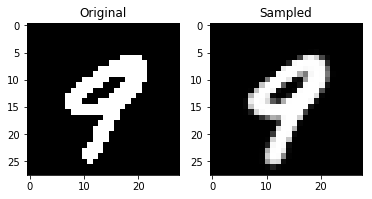

Generate another?


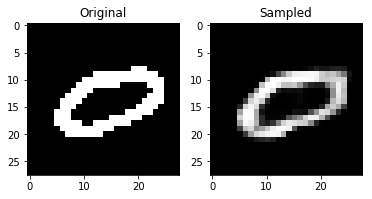

Generate another?


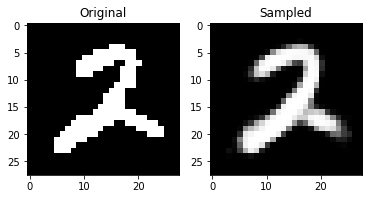

Generate another?


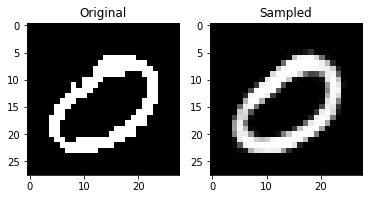

Generate another?


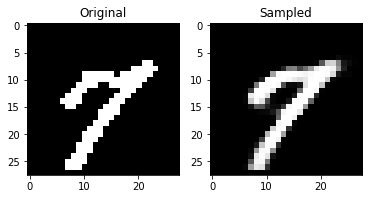

Generate another?


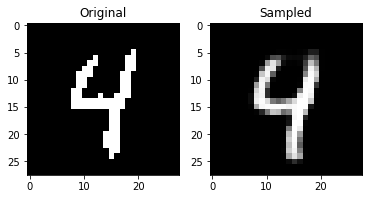

Generate another?


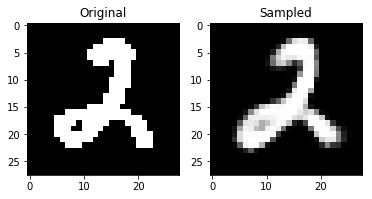

Generate another?n


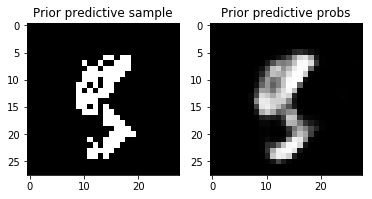

Generate another?


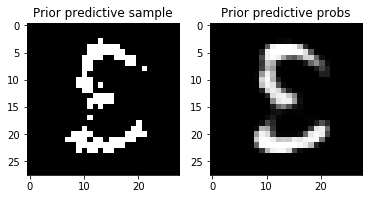

Generate another?


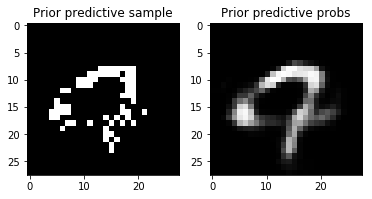

Generate another?


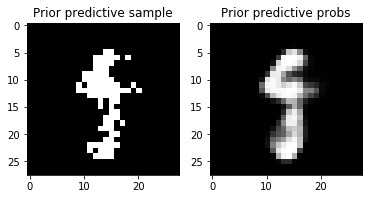

Generate another?n


In [65]:
if __name__=='__main__':
    test_vae()